# PCA降维
这里展示一下pca降纬的方法，这里介绍sklearn调用pca实现降维，以及自己python实现pca降维。

首先导入包

In [46]:
import numpy as np
import torch
import torch.nn as nn
import transformers
from transformers import BertConfig, BertModel, BertTokenizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # 加载PCA算法包

然后我们先得到一些数据，作为我们最后降维结果的一个展示。  
这里我们使用bert来embed一些句子，然后来降维展示。

In [3]:
# 先加载模型
pretrained_model_path = '../Bert_recall/Bert_cn'
tokenizer_path = '../Bert_recall/Bert_cn/vocab.txt'

# 直接加载预训练的中文bert模型
Model = BertModel.from_pretrained(pretrained_model_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path, do_lower_case=True)

Some weights of the model checkpoint at ../Bert_recall/Bert_cn were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1706: FutureWarning: Calling BertTokenizer.from_pretrained() with the p

我们先定义一些句子，然后用bert生成句向量，在pca降维后展示。

In [44]:
# 4行句子，分别代表逻辑上的4类句子
words = ['找个老师辅导', '找些保安来', '招聘英国厨师', '程序员在哪里', '我们需要医生', '我要找律师',
         '火车起火了', '汽车出了事故', '轮船撞了冰山', '摩托车翻车了', '拖拉机坏了',
         '苹果派真甜', '我喜欢吃饺子', '冰糖雪梨真好吃', '葱花饼闻着好香', '我想吃糖醋鱼',
         '航班取消了么', '航班还准时么', '航班会延误么']

# embedding
words_source = tokenizer(words,
                        max_length=10,
                        truncation=True,
                        padding='max_length',
                        return_tensors='pt')
input_ids = words_source['input_ids']               
attention_mask = words_source['attention_mask']    
token_type_ids = words_source['token_type_ids'] 

# 输出，这就是我们要降维的数据了，即几个768维的向量。
Out = Model(input_ids, attention_mask, token_type_ids, output_hidden_states=True)
cls_out = Out['last_hidden_state'][:,0]
cls_out = cls_out.detach().numpy()
# print(cls_out)

## 1. sklearn中PCA的实现
PCA降维，plt画图。

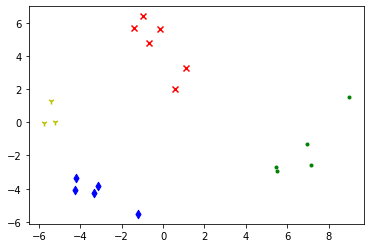

In [87]:
def showplot(data):
    # 画图函数
    x, y = [], []
    a, b = [], []
    c, d = [], []
    e, f = [], []
    for i in range(len(data)):
        if i < 6:
            x.append(data[i][0])
            y.append(data[i][1])
        elif i < 11:
            a.append(data[i][0])
            b.append(data[i][1])
        elif i < 16:
            c.append(data[i][0])
            d.append(data[i][1])
        else:
            e.append(data[i][0])
            f.append(data[i][1])
    plt.scatter(x, y, c='r', marker='x')
    plt.scatter(a, b, c='b', marker='d')
    plt.scatter(c, d, c='g', marker='.')
    plt.scatter(e, f, c='y', marker='1')
    plt.show()

pac = PCA(n_components=2)
reduced_vecs = pac.fit_transform(cls_out)
showplot(reduced_vecs)



## 2. 自己手动实现PCA
PCA就是主成分分析，也就是找到主要特征向量，然后我们把向量投影在特征向量上，这样可以尽可能到减少降维造成的信息损失。

In [91]:
def mypca(data, dim):
    # 1. 数据标准化
    mean = np.mean(data, axis=0)  # 计算均值
    data = data - mean  # 去除均值
    # 2. 计算协方差矩阵
    mat = np.cov(data, rowvar=False)
    # 3. 计算特征值和特征向量
    eigVals, eigVets = np.linalg.eig(np.mat(mat))  # 计算矩阵的特征值和特征向量
    eigValInd = np.argsort(eigVals)  # 将特征值从小到大排序，得到索引
    eigValInd = eigValInd[::-1]  #特征值从大到小到索引
    eigValInd = eigValInd[:dim]  # 保留最大的前K个特征值的索引
    redEigVects = eigVets[:, eigValInd]  # 对应的特征向量
    # 4. 投影
    data = data * redEigVects
    data = data.getA()  # matrix转array
    return data

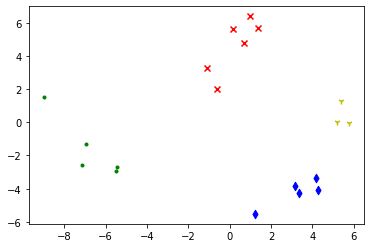

In [92]:
reduced_vecs = mypca(cls_out,2)
showplot(reduced_vecs)